## Investigation of Building Permit Approval Times in San Francisco, CA 
## Master Notebook

### 1. Data Synthesis

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime
from time import time
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

#### Import (Cleaned) Data from GitHub Repository
*parcels_taxvals_merged*: SF Tax Assessor's data (Property Area, Total Taxable Value), merged onto SF land parcels

*SFDBIPermit*: New construction permits (2013-2021) from SF Dept. of Building Inspections

*sf_census_data*: Median household income in SF by parcel (GeoDataFrame)

All data in GitHub repository.

In [3]:
parcels_taxvals_merged = pd.read_csv('Data/parcels_taxvals_merged.csv', index_col = 0)

SFDBIPermit = pd.read_csv('Data/SFDBI_Permits.csv')

sf_census_data = gpd.read_file('Data/Block Group Median Household Income.geojson')

#### Merging tax assessor's data with SFDBI data (*tax_dbi_merge*)
Merging on parcel number (AKA mapblklot)

In [4]:
tax_dbi_merge = parcels_taxvals_merged.merge(SFDBIPermit, how='inner', left_on='mapblklot', right_on='Parcel Number')

#### Convert to GeoDataFrame for future spatial join
Use a well-known text representation of geometry column as the geometry column in the GeoDataFrame

In [5]:
tax_dbi_merge['geometry_y'] = gpd.GeoSeries.from_wkt(tax_dbi_merge['geometry_y'])
tax_dbi_merge_geo = gpd.GeoDataFrame(data = tax_dbi_merge, crs= 'EPSG:4326', geometry= 'geometry_y')

#### Spatial join data with census data to make a master dataframe (*master_merge*)

In [6]:
master_merge = tax_dbi_merge_geo.sjoin(sf_census_data, how = 'inner')

#### Extract all relevant columns to get a regression table
Rename columns to become more machine-readable for *statsmodels*

In [7]:
Regression_Table = master_merge.loc[:,['wait_time','Number of Rooms','Property Area',
                                 'Total Taxable Value','revised_cost','site_permit','estimated_cost', 
                                 'proposed_units','number_of_proposed_stories','year', 'Median household income', 'zoning_code']]

feature_dict = {'Median household income':'median_income', 'Number of Rooms': 'num_rooms',
                'Property Area': 'property_area', 'Total Taxable Value':'total_taxable_value'}

Regression_Table.rename(columns=feature_dict, inplace = True)

#### Classify the *zoning_code* column into four categories for categorical variable creation
*res_low_density*: refers to parcels that are residential/mixed-use, with 3 or less housing units

*res_high_density*: refers to parcels that are residential/mixed-use with 4 or more housing units

*comm*: refers to parcels with exclusively commerical land use

*misc*: refers to parcels with miscellaneous non-residential/mixed-use/commerical land use (e.g. industrial, warehousing)

Zoning code abbreviations/definitions were taken from the San Francisco Zoning Code: https://codelibrary.amlegal.com/codes/san_francisco/latest/sf_planning/0-0-0-19797



In [30]:
zoning_dict = {'C-2':'comm', 
               'RH-3': 'res_low_density',
               'RH-1(D)': 'res_low_density',
               'RM-1': 'res_low_density',
               'RC-3': 'res_high_density',
               'RM-3': 'res_high_density',
               'RC-4': 'res_high_density',
               'C-3-G': 'comm',
               'RH-1': 'res_low_density',
               'NC-2': 'comm',
               'NC-3': 'comm',
               'RH-2': 'res_low_density',
               'NCD': 'comm',
               'RM-4': 'res_high_density',
               'NCT': 'comm',
               'NCT-3': 'comm',
               'RTO': 'res_high_density',
               'NC-1': 'comm',
               'RH-1(S)': 'res_low_density',
               'WMUG': 'res_high_density',
               'UMU': 'res_high_density',
               'C-3-S': 'comm',
               'RED-MX': 'res_high_density',
               'RCD': 'res_high_density',
               'RTO-M': 'res_high_density',
               'RED': 'res_high_density',
               'MUG': 'comm',
               'C-3-O(SD)': 'comm',
               'MUR': 'res_high_density',
               'TB DTR': 'res_high_density',
               'RH DTR': 'res_high_density',
               'CMUO': 'res_high_density',
               'PDR-1-D': 'comm',
               'MB-RA': 'res_high_density',
               'PDR-1-G': 'comm',
               'RM-2': 'res_high_density',
               'HP-RA|M-1|RM-1': 'res_low_density',
               'HP-RA': 'misc',
               'HP-RA|RM-1': 'res_low_density',
               'P|RM-1': 'res_low_density',
               'M-1': 'misc',
               'NCD|RH-1': 'res_low_density',
               'NC-1|RH-2': 'res_low_density',
               'PM-R': 'res_high_density',
               'PM-R|RM-1': 'res_high_density',
               'TI-MU|TI-OS': 'misc',
               'YBI-PCI|YBI-R|YBI-OS': 'misc'}

Regression_Table = Regression_Table.replace({'zoning_code': zoning_dict})
Regression_Table = Regression_Table[~Regression_Table.index.duplicated()]

#### Creating dummy variables for the zoning codes

In [35]:
Regression_Table_wDummies = pd.get_dummies(data=Regression_Table, columns = ['zoning_code'])

### 2. Exploratory Data Analysis and Filtering

#### Distribution of Permit Wait Times

Use Seaborn to visualize the distribution of permit wait times.

Text(0.5, 1.0, 'Distribution of Approval Times (n = 656)')

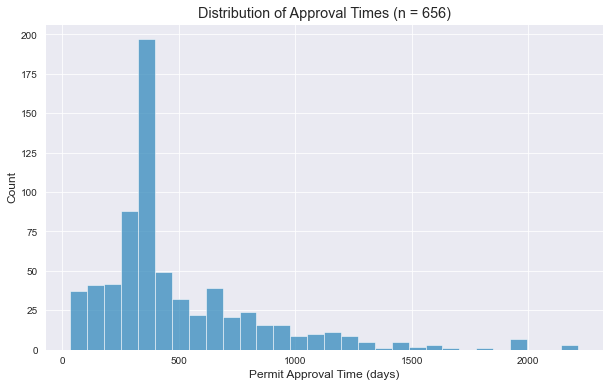

In [34]:
sns.set_style('darkgrid')
sns.histplot(x = Regression_Table['wait_time'])
plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('Permit Approval Time (days)')
plt.title('Distribution of Approval Times (n = 656)')
#plt.savefig('wait_time_dist', bbox_inches = 'tight',dpi = 300)

Median is around 300 days, which is very slow.

#### Scatter Plots of Dependent Variable vs Independent Variables, w/ Outliers

Generate scatter plots using matplotlib to see how the permit time is correlated with every regressor. Use the plots to figure out an outlier index which can be used to filter out outlier data.

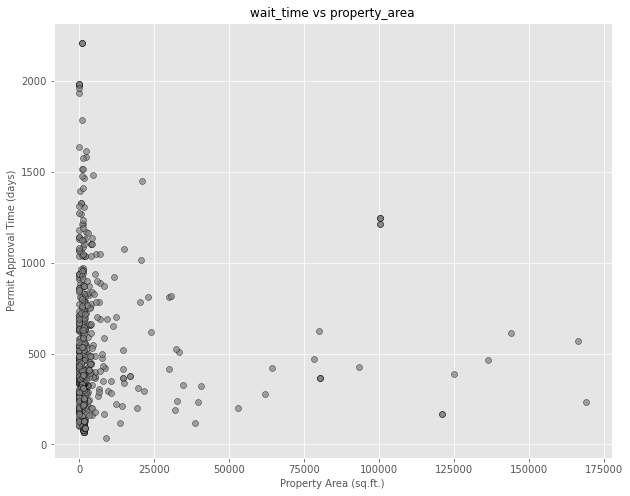

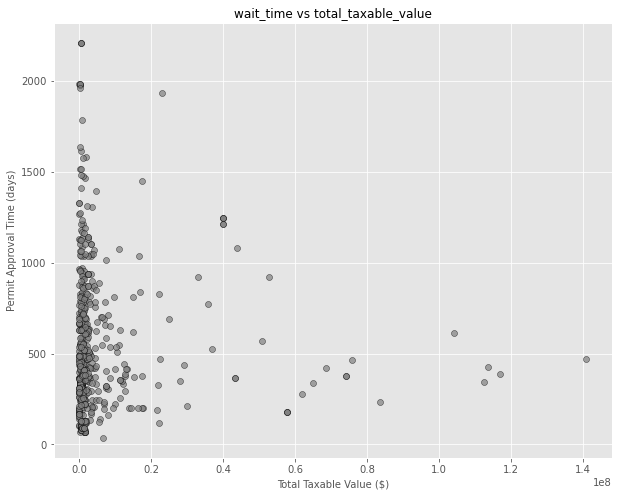

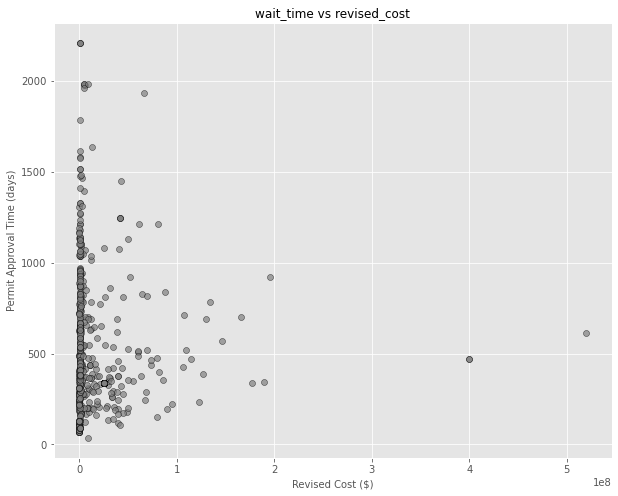

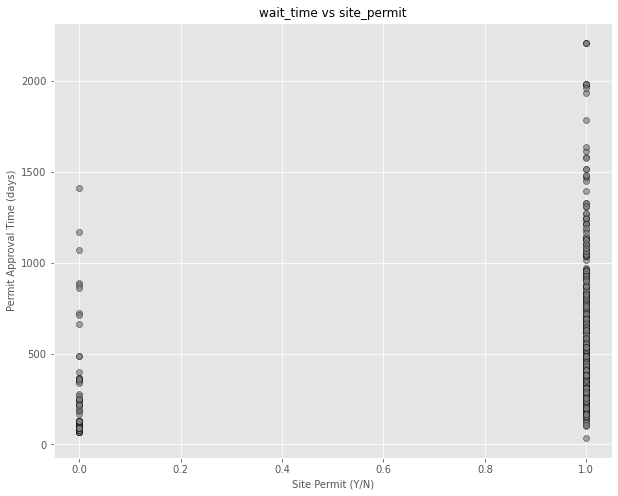

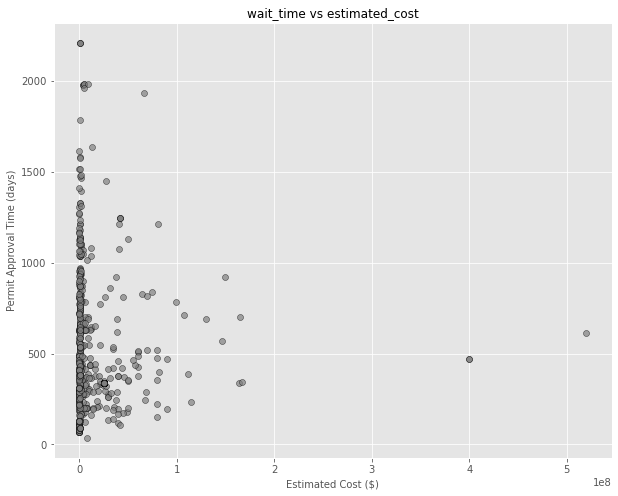

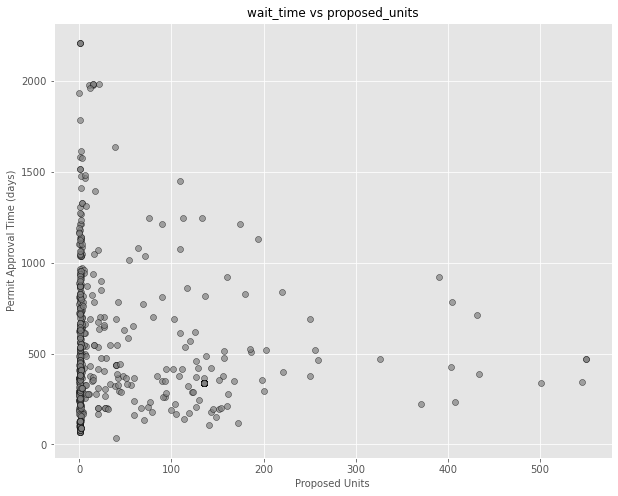

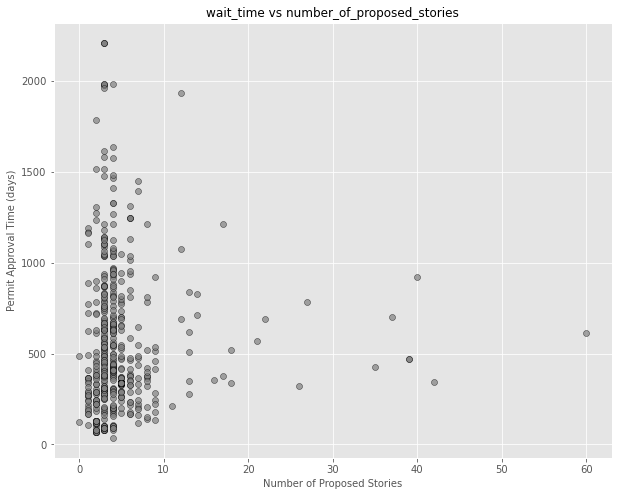

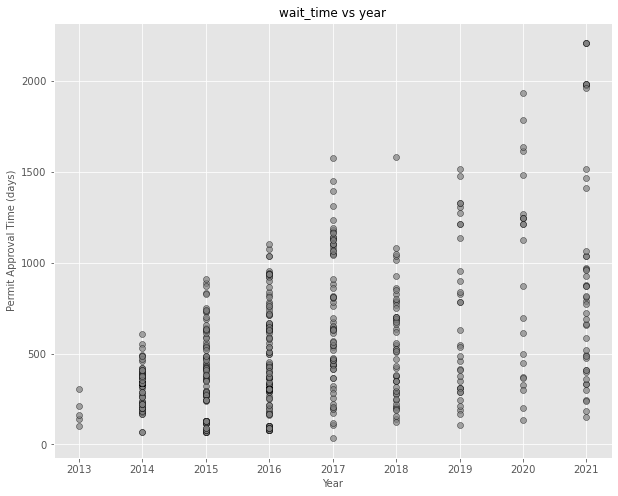

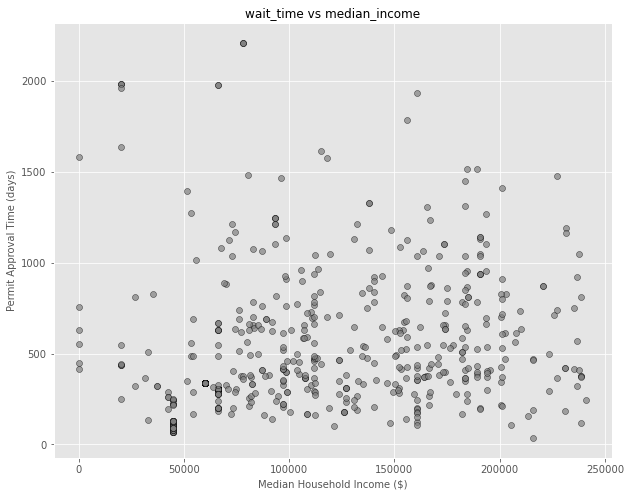

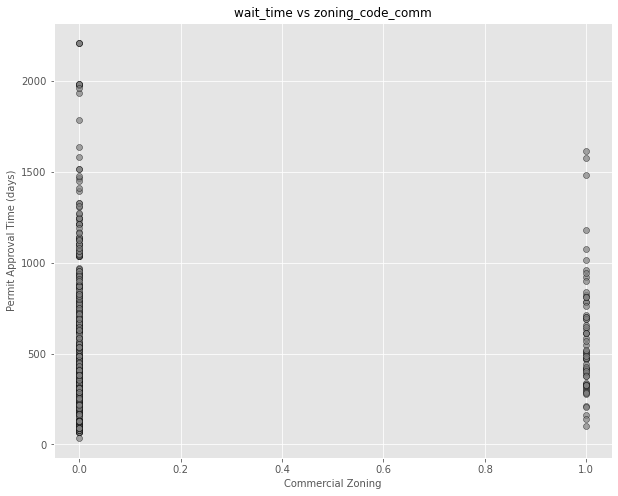

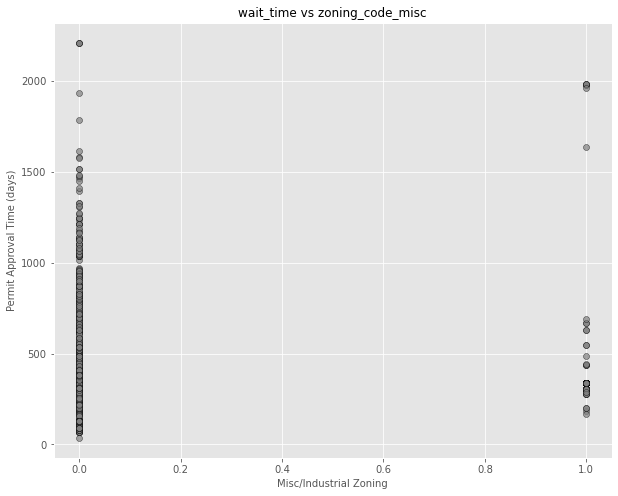

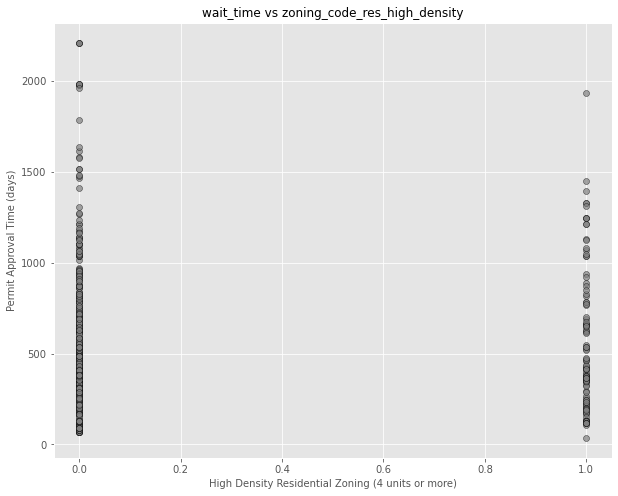

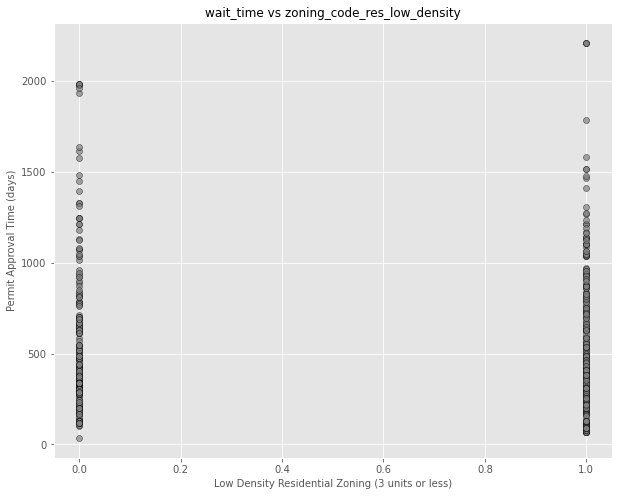

In [17]:
regressors = list(Regression_Table_wDummies.columns)[1:]
regressor_dict = {'property_area': 'Property Area (sq.ft.)','total_taxable_value':'Total Taxable Value ($)',
                 'revised_cost':'Revised Cost ($)', 'estimated_cost':'Estimated Cost ($)',
                 'site_permit':'Site Permit (Y/N)', 'proposed_units':'Proposed Units', 
                 'number_of_proposed_stories':'Number of Proposed Stories', 'year':'Year',
                 'median_income':'Median Household Income ($)', 'zoning_code_comm': 'Commercial Zoning',
                 'zoning_code_misc': 'Misc/Industrial Zoning', 
                 'zoning_code_res_low_density': 'Low Density Residential Zoning (3 units or less)',
                 'zoning_code_res_high_density': 'High Density Residential Zoning (4 units or more)'}

plt.style.use('ggplot')

for reg in regressors[1:]:
    fig, ax = plt.subplots(figsize = (10,8))
    ax.scatter(Regression_Table_wDummies[reg],Regression_Table_wDummies['wait_time'],
              edgecolor = 'k', facecolor = 'grey', alpha = 0.7)
    ax.set_xlabel(reg.replace(reg,regressor_dict[reg]), fontsize = 10)
    ax.set_ylabel('Permit Approval Time (days)', fontsize = 10)
    ax.set_title("wait_time vs {}".format(reg), fontsize = 12)
    #plt.savefig('{}.png'.format(reg), bbox_inches = 'tight', dpi = 300)

From these plots, "outlier" can be more easily defined. An outlier index can be created and the most egregious outliers are removed. For example, in a small city like San Francisco, it doesn't make much sense for a property's area to be greater than 50,000 sqft

In [36]:
outlierIndex = (Regression_Table_wDummies['num_rooms'] < 100) & \
(Regression_Table_wDummies['property_area'] < 50000) & \
(Regression_Table_wDummies['total_taxable_value'] < 0.6e8) & \
(Regression_Table_wDummies['revised_cost'] < 2e8) & \
(Regression_Table_wDummies['estimated_cost'] < 2e8) & \
(Regression_Table_wDummies['proposed_units'] < 300) & \
(Regression_Table_wDummies['number_of_proposed_stories'] < 30)

Regression_Table_wDummies_no_outliers = Regression_Table_wDummies.loc[outlierIndex]

#make a table without dummies, for future regression analysis
Regression_Table_no_outliers_no_dummy = Regression_Table.loc[outlierIndex].drop(columns = 'zoning_code').reset_index(drop = True)

#### Scatter Plots of Dependent Variable vs Independent Variables, w/o Outliers

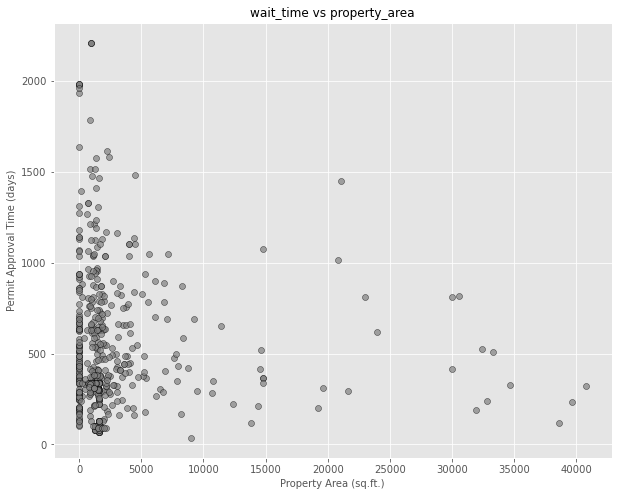

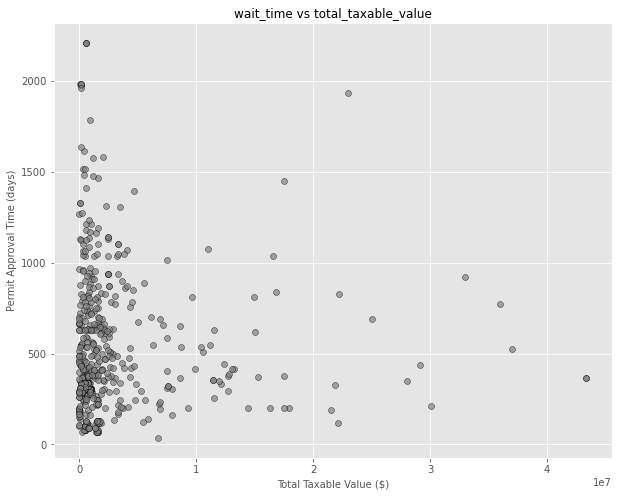

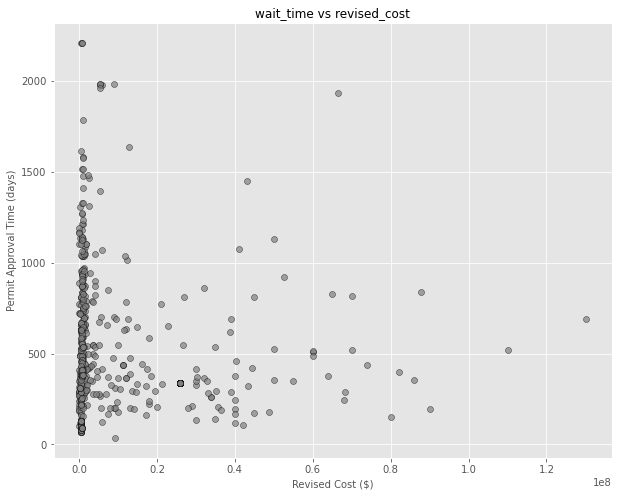

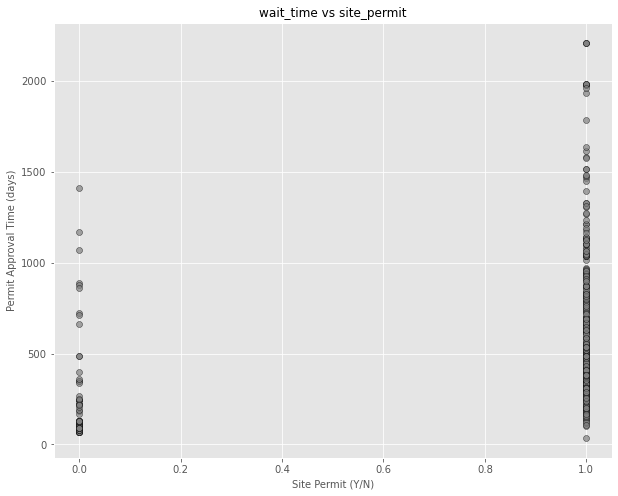

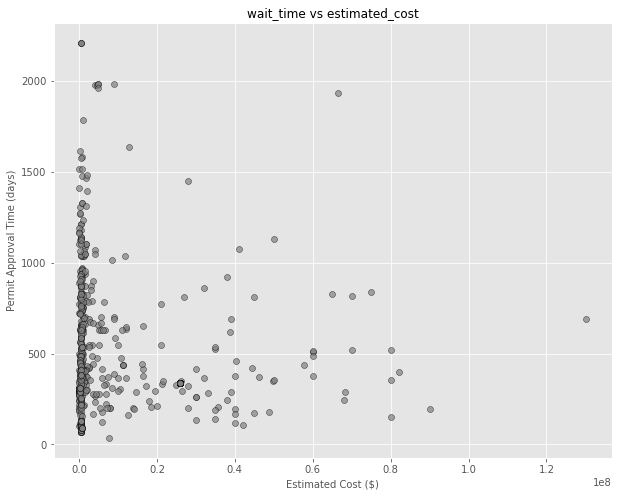

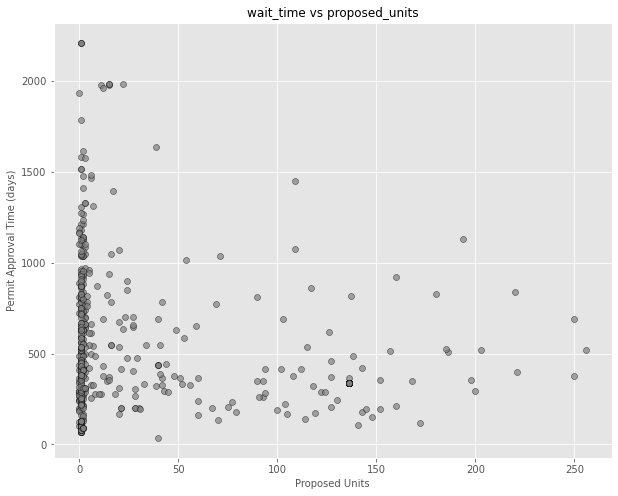

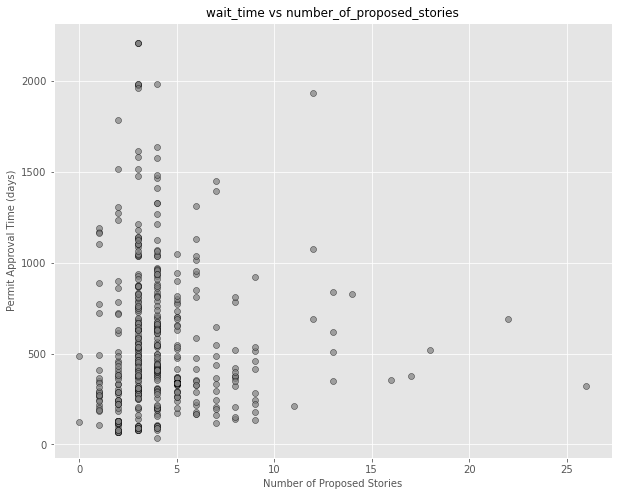

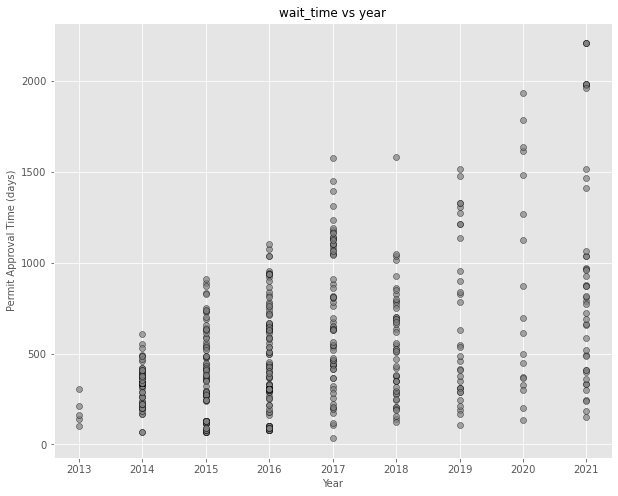

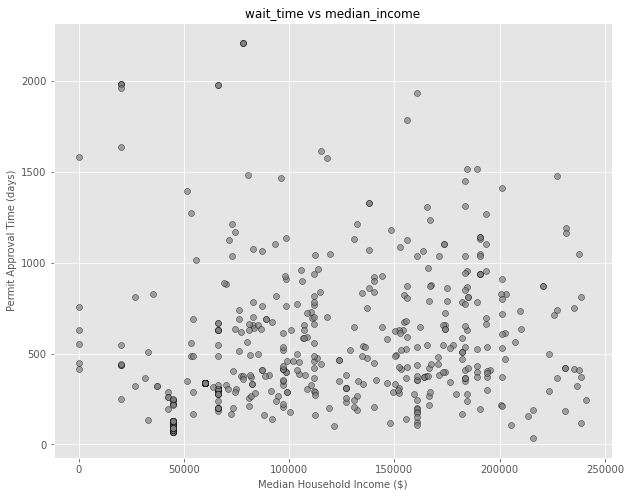

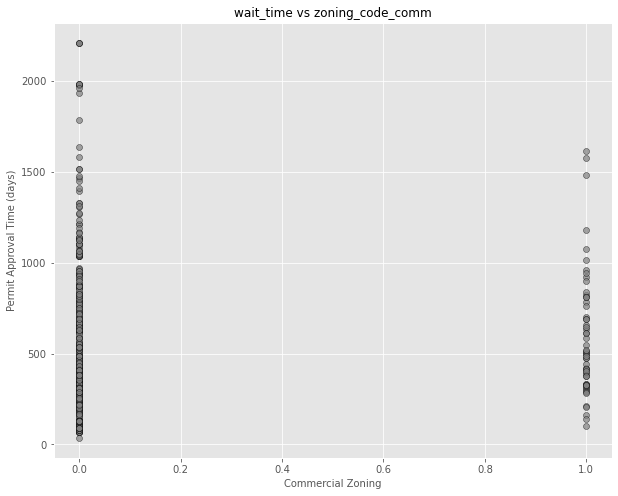

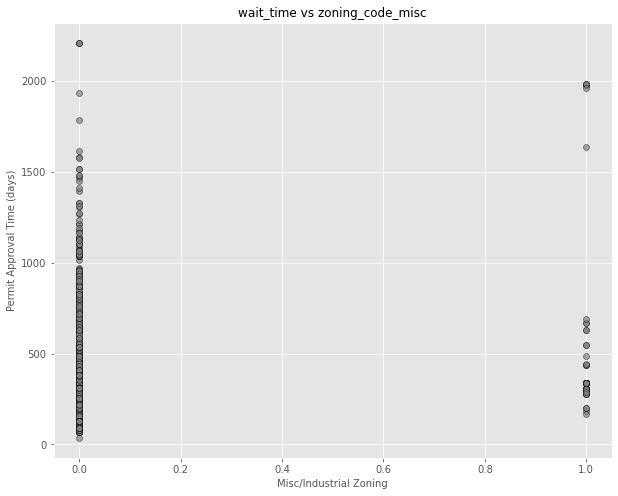

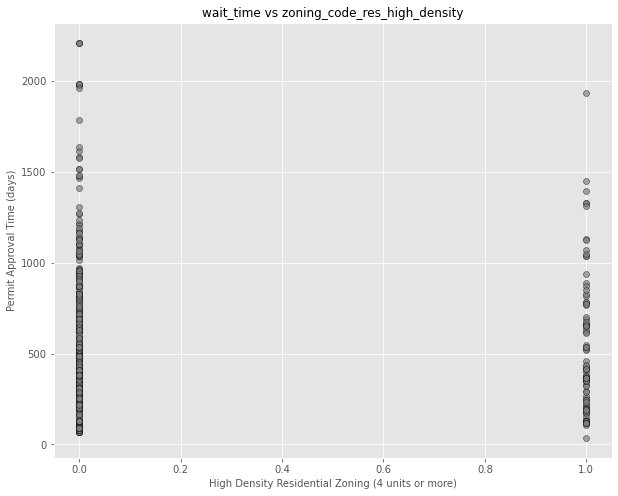

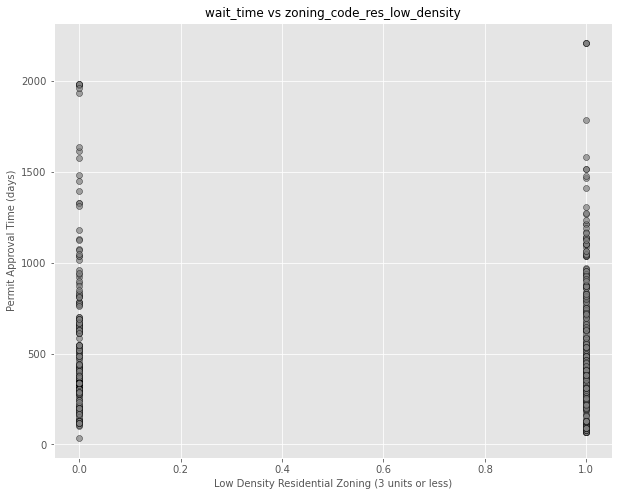

In [18]:
regressors = list(Regression_Table_wDummies_no_outliers.columns)[1:]
regressor_dict = {'property_area': 'Property Area (sq.ft.)','total_taxable_value':'Total Taxable Value ($)',
                 'revised_cost':'Revised Cost ($)', 'estimated_cost':'Estimated Cost ($)',
                 'site_permit':'Site Permit (Y/N)', 'proposed_units':'Proposed Units', 
                 'number_of_proposed_stories':'Number of Proposed Stories', 'year':'Year',
                 'median_income':'Median Household Income ($)', 'zoning_code_comm': 'Commercial Zoning',
                 'zoning_code_misc': 'Misc/Industrial Zoning', 
                 'zoning_code_res_low_density': 'Low Density Residential Zoning (3 units or less)',
                 'zoning_code_res_high_density': 'High Density Residential Zoning (4 units or more)'}

plt.style.use('ggplot')

for reg in regressors[1:]:
    fig, ax = plt.subplots(figsize = (10,8))
    ax.scatter(Regression_Table_wDummies_no_outliers[reg],Regression_Table_wDummies_no_outliers['wait_time'],
              edgecolor = 'k', facecolor = 'grey', alpha = 0.7)
    ax.set_xlabel(reg.replace(reg,regressor_dict[reg]), fontsize = 10)
    ax.set_ylabel('Permit Approval Time (days)', fontsize = 10)
    ax.set_title("wait_time vs {}".format(reg), fontsize = 12)
    #plt.savefig('{}.png'.format(reg), bbox_inches = 'tight', dpi = 300)

#### Feature Multicollinearity Heat Matrix

Assess multicollinearity of every regressor by creating a heat matrix. This information will be valuable during model selection, so that any features that are selected have minimal multicollinearity, which can affect the statistical rigourousness of the model.

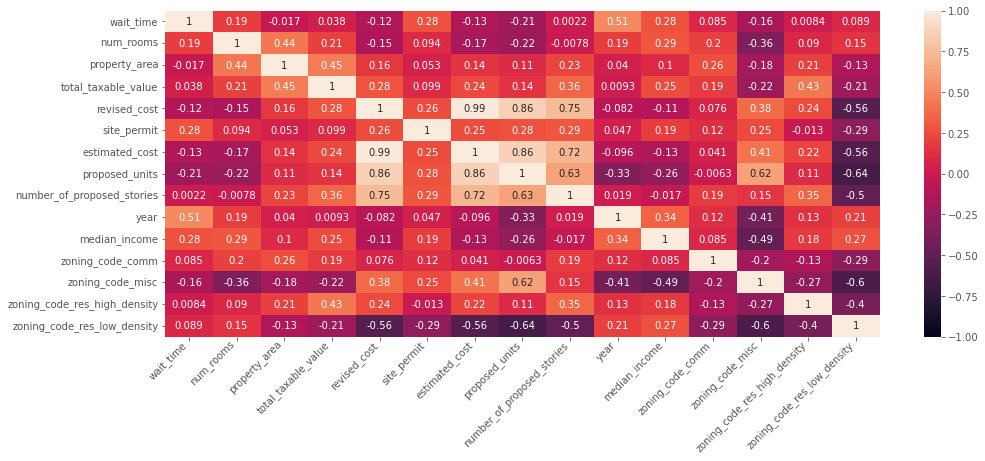

In [19]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(Regression_Table_wDummies_no_outliers.corr(), vmin = -1, vmax = 1, annot = True)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='x', pad=-1)
#plt.savefig('corr_table.png', bbox_inches = 'tight', dpi = 300)

### 3. Statistical Model Building and Feature Selection

In [305]:
X = Regression_Table_wDummies.iloc[:,1:].values
y = Regression_Table_wDummies['wait_time'].values
feature_names = np.array(Regression_Table_wDummies.iloc[:,1:].columns)

In [306]:
lasso_estimator = LassoCV().fit(X,y)
lasso_selector = SequentialFeatureSelector(lasso_estimator, n_features_to_select=5, direction='forward').fit(X, y)
wDummies_lasso_features = lasso_selector.get_feature_names_out(feature_names)

lasso_model_wDummies = smf.ols(formula = 'wait_time ~ '+ '+'.join(wDummies_lasso_features), data = Regression_Table_wDummies).fit()    
print(lasso_model_wDummies.summary())

C:\Users\Rohan\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+04, tolerance: 9.021e+03
  model = cd_fast.enet_coordinate_descent(


                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     70.19
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.62e-59
Time:                        16:33:37   Log-Likelihood:                -4920.9
No. Observations:                 693   AIC:                             9854.
Df Residuals:                     687   BIC:                             9881.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [31]:
print(smf.ols(formula = 'wait_time~number_of_proposed_stories', data = Regression_Table_no_outliers_no_dummy).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.003067
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.956
Time:                        01:52:09   Log-Likelihood:                -4795.1
No. Observations:                 656   AIC:                             9594.
Df Residuals:                     654   BIC:                             9603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
base_model = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories', data = Regression_Table_wDummies_no_outliers).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     109.1
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.88e-57
Time:                        17:28:34   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9331.
Df Residuals:                     652   BIC:                             9349.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
w_low_density = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_res_low_density', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_low_density.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     81.96
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.43e-56
Time:                        17:28:54   Log-Likelihood:                -4661.4
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9355.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [37]:
w_high_density = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_res_high_density', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_high_density.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     81.99
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.35e-56
Time:                        17:29:34   Log-Likelihood:                -4661.3
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9355.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [38]:
w_comm = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_comm', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_comm.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     81.74
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           3.24e-56
Time:                        17:31:56   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [313]:
X_no_outliers = Regression_Table_wDummies_no_outliers.iloc[:,1:].values
y_no_outliers = Regression_Table_wDummies_no_outliers['wait_time'].values

In [315]:
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
lasso_selector_no_outliers = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=4, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_features_no_outliers = lasso_selector_no_outliers.get_feature_names_out(feature_names)

lasso_model_no_outliers = smf.ols(formula = 'wait_time ~ '+ '+'.join(lasso_features_no_outliers), data = Regression_Table_wDummies_no_outliers).fit()    
print(lasso_model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     81.74
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           3.24e-56
Time:                        16:40:55   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [185]:
lasso_selector_no_outliers_bck = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=5, 
                                                       direction='backward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)

In [186]:
lasso_model_no_outliers_bck = smf.ols(formula = 'wait_time ~ site_permit+year+number_of_proposed_stories+Q("zoning_code_MUR")+Q("zoning_code_RH-1(D)")', 
                                  data = Regression_Table_wDummies_no_outliers).fit()
print(lasso_model_no_outliers_bck.

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     68.07
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.31e-57
Time:                        18:09:16   Log-Likelihood:                -4657.0
No. Observations:                 656   AIC:                             9326.
Df Residuals:                     650   BIC:                             9353.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [317]:
#test for best number of features
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
sel_features = []
for num in np.arange(1,6):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names))

sel_features


[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_comm'], dtype=object),
 array(['num_rooms', 'site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_comm'], dtype=object)]

In [203]:
r2 = []
for num in np.arange(0,4):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_wDummies_no_outliers).fit()
    r2.append(lm.rsquared)
    
r2

[0.26292884876082334,
 0.3270539489511274,
 0.3314908634152024,
 0.336855352658208]

In [204]:
lasso_selector_no_outliers_10 = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=10, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers_10.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_C-3-G', 'zoning_code_HP-RA|M-1|RM-1',
       'zoning_code_HP-RA|RM-1', 'zoning_code_MUR', 'zoning_code_P|RM-1',
       'zoning_code_RH-1(D)', 'zoning_code_RM-4'], dtype=object)

In [278]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []

for num in np.arange(1,10):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

sel_features

[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'site_permit', 'number_of_proposed_stories', 'year'],
       dtype=object),
 array(['num_rooms', 'property_area', 'site_permit',
        'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'property_area', 'site_permit', 'proposed_units',
        'number_of_proposed_stories', 'year'], dtype=object)]

In [280]:
r2 = []
loglike = []

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)

,R2,Log Likelyhood
0,0.262929,-4695.083120
1,0.327054,-4665.228801
2,0.334308,-4661.674044
3,0.338908,-4659.399366
4,0.344094,-4656.816610
5,0.349108,-4654.299599


In [281]:
pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike})

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[num_rooms, site_permit, number_of_proposed_st...",0.338908,-4659.399366
4,"[num_rooms, property_area, site_permit, number...",0.344094,-4656.816610
5,"[num_rooms, property_area, site_permit, propos...",0.349108,-4654.299599


In [353]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []
r2 = []
loglike = []

for num in np.arange(1,8):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers_no_dummy).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)    
    print(lm.summary())

r2_table = pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike}); r2_table

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     233.3
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.87e-45
Time:                        17:20:45   Log-Likelihood:                -4695.1
No. Observations:                 656   AIC:                             9394.
Df Residuals:                     654   BIC:                             9403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.775e+05   1.17e+04    -15.232      0.0

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[property_area, site_permit, number_of_propose...",0.335416,-4661.127719
4,"[property_area, site_permit, proposed_units, n...",0.343933,-4656.896618
5,"[property_area, site_permit, proposed_units, n...",0.345369,-4656.178051
6,"[property_area, total_taxable_value, site_perm...",0.346933,-4655.393791


In [62]:
#final_model = smf.ols(formula = 'wait_time ~ '+ '+'.join(r2_table.iloc[2]['Features'])+'-1', data = Regression_Table_no_outliers_no_dummy).fit()
#print(final_model.summary())
final_model = smf.ols(formula = 'wait_time~site_permit+number_of_proposed_stories+year-1', data = Regression_Table_no_outliers_no_dummy).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     109.1
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           2.88e-57
Time:                        20:43:44   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9331.
Df Residuals:                     652   BIC:                             9349.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
site_permit[False]  